In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
import os
os.chdir(os.path.abspath("../src"))

In [4]:
import duckdb as ddb, ibis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd
import math

## Constants

In [7]:
database_folder_path = '../data/duckdb'
ddb_file_name = 'intermediate_files.db'

## Functions

In [8]:
def show_values_on_bars(axs, h_v="v", space=0.8, use_percent=False, text_rotation=0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _width = 0 if math.isnan(p.get_width()) else p.get_width()
                _height = 0 if math.isnan(p.get_height()) else p.get_height()
                _x = p.get_x() + _width / 2
                _y = p.get_y() + _height + float(space)
                value = (
                    f"{round(_height, 2)}"
                    if not use_percent
                    else f"{round(_height, 2)}%"
                )
                ax.text(
                    _x,
                    _y,
                    value,
                    ha="center",
                    rotation=text_rotation,
                    fontweight="bold",
                )
        elif h_v == "h":
            for p in ax.patches:
                _width = 0 if math.isnan(p.get_width()) else p.get_width()
                _height = 0 if math.isnan(p.get_height()) else p.get_height()
                _x = p.get_x() + _width + float(space)
                _y = p.get_y() + _height
                value = (
                    f"{round(_width, 2)}" if not use_percent else f"{round(_width, 2)}%"
                )
                ax.text(_x, _y, value, ha="left", fontweight="bold")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndnumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def create_multiple_plots(
    df,
    x,
    y,
    hue=None,
    col=None,
    col_order=None,
    row=None,
    order=None,
    hue_order=None,
    hue_color_dict=None,
    kind="line",
    orientation="v",
    text_rotation=0,
    marker="o",
    title=None,
    height=5,
    aspect=1,
    use_percent=False,
    space=0.8,
    ref_value_dict=None,
    bins=None
):
    if kind == "line":
        graph = sns.relplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            marker=marker,
            hue_order=hue_order,
            palette=hue_color_dict,
            col_order = col_order,
            facet_kws=dict(sharex=False, sharey=False),
        )
    elif kind == "bar":
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            order=order,
        )
    elif kind == "point":
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            sharey=False,
            order=order,
        )
    elif (kind == "box") or (kind == "violin"):
        graph = sns.catplot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            kind=kind,
            height=height,
            aspect=aspect,
            order=order,
            hue_order=hue_order,
            palette=hue_color_dict,
            sharex=False,
            sharey=True,
            col_order=col_order
        )
    elif kind == "hist":
        graph = sns.displot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            hue_order=hue_order,
            kind=kind,
            height=height,
            aspect=aspect,
            facet_kws=dict(sharex=False, sharey=False),
            palette=hue_color_dict,
            stat="probability",
            bins=bins,
            alpha=0.5,
        )
    elif kind == "kde":
        graph = sns.displot(
            data=df,
            x=x,
            y=y,
            col=col,
            row=row,
            hue=hue,
            hue_order=hue_order,
            kind=kind,
            height=height,
            aspect=aspect,
            facet_kws=dict(sharex=False, sharey=False),
            palette=hue_color_dict,
        )

    if ref_value_dict is not None:
        print(ref_value_dict)
        if "x" in ref_value_dict:
            graph.refline(x=ref_value_dict.get("x"), color="red", lw=3)
        if "y" in ref_value_dict:
            graph.refline(y=ref_value_dict.get("y"), color="blue", lw=3)

    if title is not None:
        graph.fig.subplots_adjust(top=0.8)
        graph.fig.suptitle(title, fontsize=20)

    for axes in graph.axes.flat:
        if kind == "bar" and orientation == "h":
            _ = axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
            show_values_on_bars(axes, orientation, space, use_percent=use_percent)
        else:
            _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
            if kind == "bar":
                show_values_on_bars(
                    axes,
                    orientation,
                    space,
                    use_percent=use_percent,
                    text_rotation=text_rotation,
                )

    plt.subplots_adjust(hspace=2.2)
    return graph

In [9]:
def plot_graphs_by_looping(df, row_identifier, column_identifier, x_column_to_plot, y_column_to_plot, row_count, max_column_count):
    fig, axs = plt.subplots(row_count,max_column_count, figsize=[5*max_column_count,5*row_count]) ##, figsize=[20,20]
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    
    for i, continent_name in enumerate(df[row_identifier].unique()):
        continent_count_df = df[df[row_identifier] == continent_name]
        for j, sub_continent_name in enumerate(continent_count_df[column_identifier].unique()):
            sub_continent_count_df = continent_count_df[continent_count_df[column_identifier] == sub_continent_name]
            sns.barplot(data=sub_continent_count_df, x=x_column_to_plot, y=y_column_to_plot, ax=axs[i][j])
            axs[i][j].title.set_text(f"{sub_continent_name}")
    plt.close()
    return fig

In [10]:
def get_row_column_count_in_ddb_table(con, table_name):
    row_count_df = con.execute(f"select count(*) as row_count from {table_name};").df()
    row_count = row_count_df['row_count'].loc[0]

    column_count_df = con.execute(f"select count(*) as column_count from information_schema.columns where table_name = '{table_name}';").df()
    column_count = column_count_df['column_count'].loc[0]
    return (row_count, column_count)

In [11]:
def get_counts_for_column_entries_ddb_table(con, table_name, count_column_name, group_by_column_list, is_distinct_count=False):
    if isinstance(group_by_column_list, list):
        group_by_column_name = ','.join(group_by_column_list)

    if not is_distinct_count:
        ## #con.execute(f"select geo_network_continent, geo_network_sub_continent, count(*) from intermediate_train_data group by geo_network_continent, geo_network_sub_continent").df()
        count_df = con.execute(f"select {group_by_column_name}, count(*) AS row_count_{count_column_name} FROM {table_name} GROUP BY {group_by_column_name} ORDER BY row_count_{count_column_name} DESC;").df()
        return count_df
    else:
        ##select full_visitor_id, COUNT(DISTINCT(channel_grouping)) AS unique_channel_grouping from intermediate_train_data GROUP BY full_visitor_id
        unique_count_df = con.execute(f"select {group_by_column_name}, COUNT(DISTINCT({count_column_name})) AS unique_count_{count_column_name} FROM {table_name} GROUP BY {group_by_column_name} ORDER BY unique_count_{count_column_name} DESC;").df()
        return unique_count_df

In [12]:
def get_separator_separated_values_for_column(con, table_name, count_column_name, group_by_column_name, is_distinct_count=False, separator=','):
    if is_distinct_count:
        res_df = con.execute(f"select {group_by_column_name}, array_to_string(list_sort(string_split(STRING_AGG(DISTINCT({count_column_name}), '{separator}'), '{separator}')), '{separator}') AS concatenated_unique_{count_column_name} from {table_name} group by {group_by_column_name}").df()
        return res_df

In [193]:
def get_aggregates_for_numerical_variable_using_groupby_column(con, table_name, numeric_column_name, group_by_column_list, is_per_session=True):
    if isinstance(group_by_column_list, list):
        group_by_column_name = ','.join(group_by_column_list)
    if is_per_session:
        return con.execute(f"select {group_by_column_name}, min(CAST({numeric_column_name} AS DOUBLE)) AS min_{numeric_column_name}_per_session, max(CAST({numeric_column_name} AS DOUBLE)) AS max_{numeric_column_name}_per_session, SUM(CAST({numeric_column_name} AS DOUBLE)) AS sum_{numeric_column_name}, AVG(COALESCE(CAST({numeric_column_name} AS DOUBLE), 0)) AS avg_{numeric_column_name}_per_session, median(CAST({numeric_column_name} AS DOUBLE)) AS median_{numeric_column_name}_per_session, COUNT(visit_number) AS session_count from {table_name} group by {group_by_column_name};").df()

## Create a connection to duckdb file and register intermediate data that is the result of handle_raw_data pipeline

In [14]:
#con = ibis.duckdb.connect(database=os.path.join(database_folder_path, ddb_file_name), read_only=True)
con = ddb.connect(database=os.path.join(database_folder_path, ddb_file_name), read_only=True)

In [15]:
intermediate_data_table = con.table('intermediate_train_data')

In [16]:
#intermediate_data_table = con.table('intermediate_train_data')
print(f"Shape of table: {get_row_column_count_in_ddb_table(con, 'intermediate_train_data')}")
#print(f'Shape of intermediate_data_table: {(intermediate_data_table.count().execute(), len(intermediate_data_table.schema()))}')

Shape of table: (1708337, 58)


## One row in the dataset refers to one visit to the Google Store. 

## Analyze different columns

### 1. Analyse channel_grouping column

### 1.1 How many rows have a given channel_grouping value associated with them?

In [17]:
channel_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_list=['channel_grouping'])

In [18]:
# channel_df = intermediate_data_table['channel_grouping'].value_counts().execute()
# channel_df = channel_df.sort_values(by=['channel_grouping_count'], ascending=False)

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


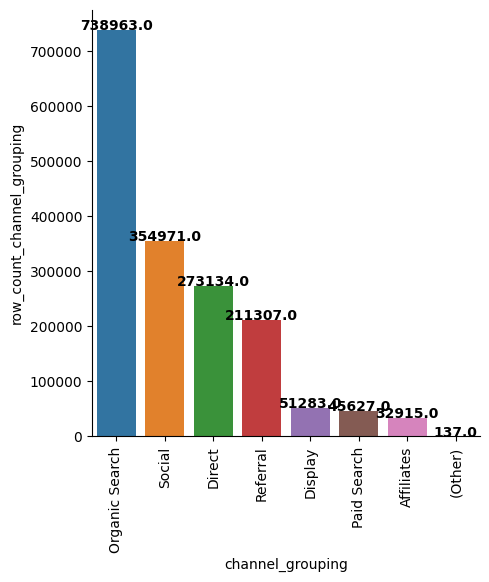

In [19]:
create_multiple_plots(df=channel_df, x='channel_grouping', y='row_count_channel_grouping', kind='bar', orientation='v')

- Most common channel_grouping is Organic Search. It will be nice to see how it changes fir a person.

### 1.2 How many unique channel_grouping values are associated with a user identified by full_visitor_id

In [20]:
unique_channel_grouping_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [21]:
unique_channel_grouping_per_user_df['unique_count_channel_grouping'].value_counts()

unique_count_channel_grouping
1    1291102
2      36018
3       2190
4        111
5         12
6          1
Name: count, dtype: int64

- This shows that majority of visitors (1291102) use only 1 unique channel_grouping. Only 1 person uses 6 channel groupings.

### 1.3 What are the comma separated unique channel_grouping values associated with each full_visitor_id

In [22]:
#res_df = con.execute(f"select full_visitor_id, STRING_AGG(DISTINCT(channel_grouping), ',') AS concatenated_unique_channel_grouping from intermediate_train_data group by full_visitor_id").df()
unique_channel_grouping_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='channel_grouping', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [23]:
merged_unique_channel_grouping_string_df = pd.merge(unique_channel_grouping_string_df, unique_channel_grouping_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [24]:
merged_unique_channel_grouping_string_df[merged_unique_channel_grouping_string_df.unique_count_channel_grouping == 1]['concatenated_unique_channel_grouping'].value_counts()

concatenated_unique_channel_grouping
Organic Search    576201
Social            325886
Direct            195091
Referral          112865
Display            32352
Paid Search        25331
Affiliates         23347
(Other)               29
Name: count, dtype: int64

- Clearly, Organic Search is the most common channel via which users arrive at the GStore for the users who have one unique channel_grouping associated with them

### 2. Analyse social_engagement_type column [REMOVE THIS COLUMN]

In [25]:
social_engagement_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='social_engagement_type', group_by_column_list=['social_engagement_type'])

In [26]:
social_engagement_df

,social_engagement_type,row_count_social_engagement_type
0,Not Socially Engaged,1708337


- Clearly all the rows have common value Not Socially Engaged. Delete this column

### 3. Analyze visit_number column (An identifier for this session. It is unique for a visitor. It can help to understand how many sessions a given visitor was involved in)

### 3.1 How many unique visit_number values are associated with a user identified by full_visitor_id

In [27]:
unique_visit_number_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='visit_number', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [28]:
unique_visit_number_per_user_df.head()

,full_visitor_id,unique_count_visit_number
0,1957458976293878100,400
1,7282998257608986241,315
2,3884810646891698298,268
3,7477638593794484792,218
4,824839726118485274,209


### 3.2 Quartile analysis of unique_count_visit_number

In [29]:
unique_visit_number_per_user_df.unique_count_visit_number.describe()

count    1.329434e+06
mean     1.281251e+00
std      1.520005e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+02
Name: unique_count_visit_number, dtype: float64

- It is clear from the graph that 75% of users have 1 session associated with them.  

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_14910/2696475345.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


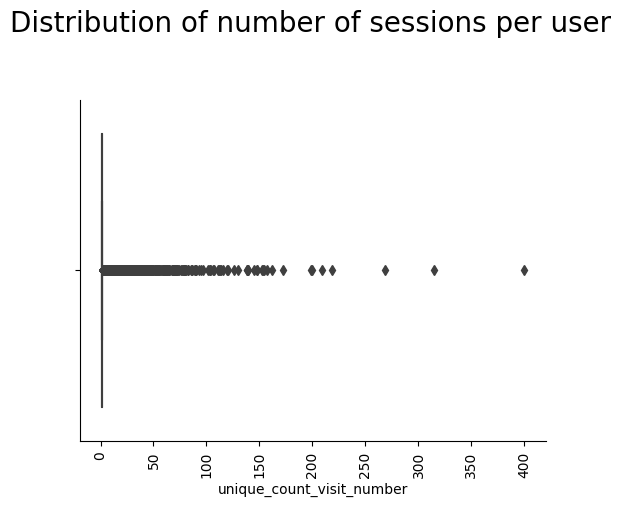

In [30]:
create_multiple_plots(df=unique_visit_number_per_user_df, x='unique_count_visit_number', y=None, kind='box', title='Distribution of number of sessions per user')

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/qr/cmfkzy495k7b3bn80b7ygs080000gn/T/ipykernel_14910/2696475345.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


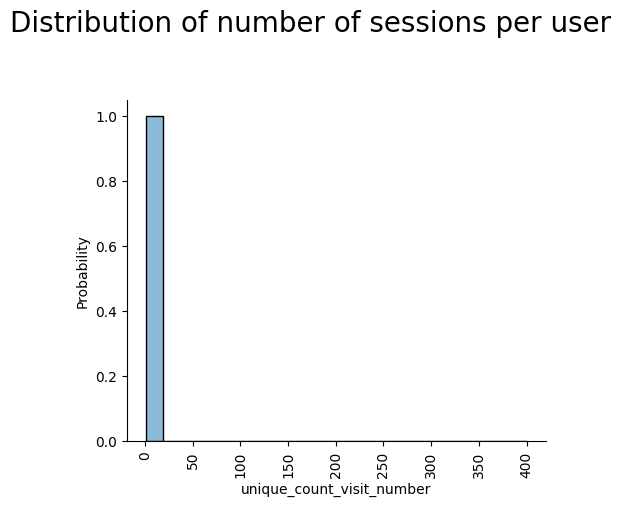

In [31]:
create_multiple_plots(df=unique_visit_number_per_user_df, x='unique_count_visit_number', y=None, kind='hist', bins='auto', title='Distribution of number of sessions per user')

- It is clear that the number of sessions per user is heavily right skewed i.e. lumped on the left with tail at the right

## 4. Analyse visit_start_time (The timestamp (expressed as POSIX time))

In [32]:
#con.execute("select TO_TIMESTAMP(visit_start_time) AS utc_visit_start_time, date, geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_city, totals_transactions	 from intermediate_train_data").df()

## 5. Analyze geo_network_continent

### 5.1 How many rows have a given geo_network_continent value associated with them?

In [33]:
geo_network_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_list=['geo_network_continent'])

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


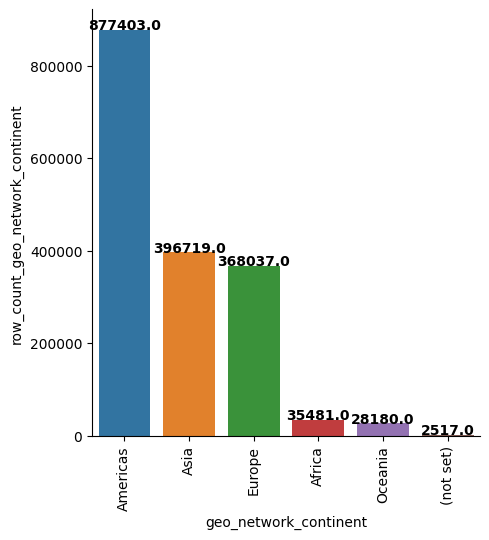

In [34]:
create_multiple_plots(df=geo_network_continent_df, x='geo_network_continent', y='row_count_geo_network_continent', kind='bar', orientation='v')

- Clearly majority if visits are from Americas

### 5.2 How many unique geo_network_continent values are associated with a user identified by full_visitor_id

In [35]:
unique_geo_network_continent_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [36]:
unique_geo_network_continent_per_user_df.unique_count_geo_network_continent.value_counts()

unique_count_geo_network_continent
1    1326922
2       2460
3         50
4          2
Name: count, dtype: int64

- This shows that majority of full_visitor_id are associated with only one continent. However, there are certain  full_visitor_id that are associated with multiple unique geo_network_continent values
- This implies that we cannot assume that full_visitor_id is linked to only one continent.

### 5.3 What are the comma separated unique geo_network_continent values associated with each full_visitor_id?

In [37]:
unique_geo_network_continent_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_continent', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [38]:
merged_unique_geo_network_continent_string_df = pd.merge(unique_geo_network_continent_string_df, unique_geo_network_continent_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [39]:
merged_unique_geo_network_continent_string_df[merged_unique_geo_network_continent_string_df.unique_count_geo_network_continent == 1]['concatenated_unique_geo_network_continent'].value_counts()

concatenated_unique_geo_network_continent
Americas     625354
Asia         337318
Europe       306088
Africa        32149
Oceania       23920
(not set)      2093
Name: count, dtype: int64

## 6. Analyze geo_network_sub_continent

### 6.1 Get continent to subcontinent mapping 

In [40]:
continent_subcontinent_mapping_df = con.execute(f"select DISTINCT(geo_network_continent, geo_network_sub_continent) AS continent_dict from intermediate_train_data;").df()

In [41]:
continent_subcontinent_mapping_df.loc[:, ['geo_network_continent', 'geo_network_sub_continent']] = continent_subcontinent_mapping_df.apply(lambda row: row.continent_dict, axis='columns', result_type='expand')

In [42]:
geo_network_continent_sub_continent_mapping = dict(zip(continent_subcontinent_mapping_df.geo_network_sub_continent.values, continent_subcontinent_mapping_df.geo_network_continent.values))

### 6.2 How many rows have a given geo_network_sub_continent value associated with them?

In [43]:
geo_network_sub_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['geo_network_sub_continent'])

In [44]:
#geo_network_sub_continent_df['geo_network_continent'] = geo_network_sub_continent_df['geo_network_sub_continent'].map(geo_network_continent_sub_continent_mapping)

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


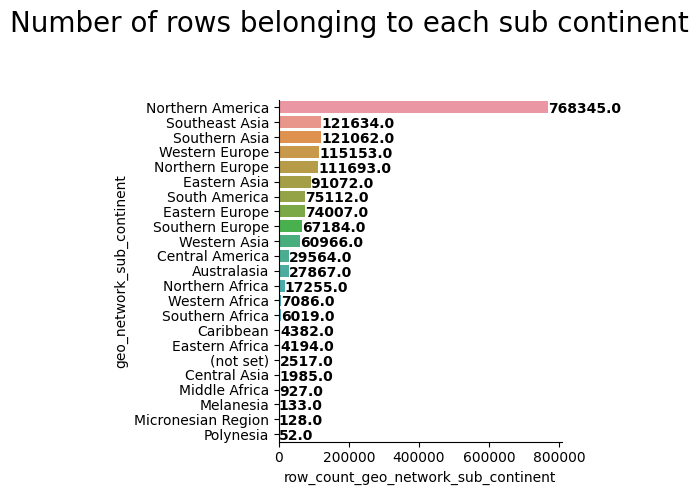

In [45]:
create_multiple_plots(df=geo_network_sub_continent_df, y='geo_network_sub_continent', x='row_count_geo_network_sub_continent', kind='bar', orientation='h', title='Number of rows belonging to each sub continent')

### 6.3 How many rows have a given (geo_network_sub_continent, geo_network_sub_continent) value associated with them?

In [46]:
geo_network_continent_and_sub_continent_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['geo_network_continent', 'geo_network_sub_continent'], is_distinct_count=False)
#con.execute(f"select geo_network_continent, geo_network_sub_continent, count(*) from intermediate_train_data group by geo_network_continent, geo_network_sub_continent").df()

In [47]:
geo_network_continent_and_sub_continent_df['combine_continent_sub_continent'] = geo_network_continent_and_sub_continent_df['geo_network_continent'] + '_' + geo_network_continent_and_sub_continent_df['geo_network_sub_continent']

/Users/hardiksahi/miniconda3/envs/personal_env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


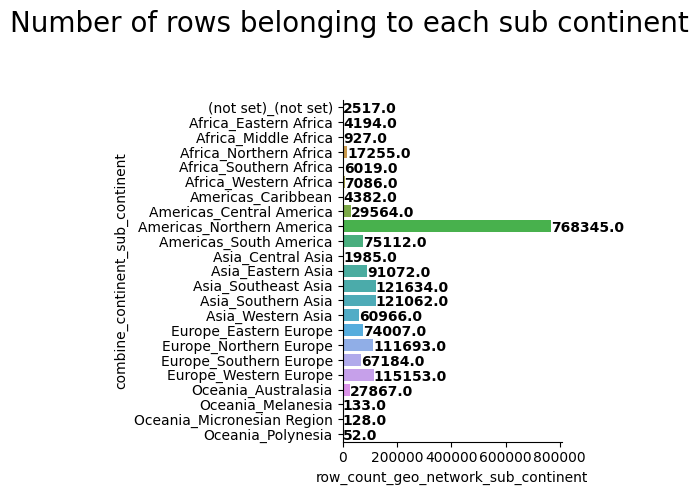

In [48]:
create_multiple_plots(df=geo_network_continent_and_sub_continent_df.sort_values(by=['combine_continent_sub_continent']), y='combine_continent_sub_continent', x='row_count_geo_network_sub_continent', kind='bar', orientation='h', title='Number of rows belonging to each sub continent')

- It can be seen that Northern America has highest number of rows in the dataset

### 6.4 How many unique geo_network_sub_continent values are associated with a user identified by full_visitor_id

In [49]:
unique_geo_network_sub_continent_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [50]:
unique_geo_network_sub_continent_per_user_df.unique_count_geo_network_sub_continent.value_counts()

unique_count_geo_network_sub_continent
1    1326063
2       3243
3        115
4         12
5          1
Name: count, dtype: int64

- Clearly, majority of people/ visitors are associated with 1 unique sub continenet. However, we see 1 person who has 5 unique sub continents

### 6.5 What are the comma separated unique geo_network_sub_continent values associated with each full_visitor_id?

In [51]:
unique_geo_network_sub_continent_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='geo_network_sub_continent', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [52]:
merged_unique_geo_network_sub_continent_string_df = pd.merge(unique_geo_network_sub_continent_string_df, unique_geo_network_sub_continent_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [53]:
merged_unique_geo_network_sub_continent_string_df[merged_unique_geo_network_sub_continent_string_df.unique_count_geo_network_sub_continent == 1]['concatenated_unique_geo_network_sub_continent'].value_counts()

concatenated_unique_geo_network_sub_continent
Northern America      534042
Southeast Asia        106812
Southern Asia         104420
Western Europe         94711
Northern Europe        92476
Eastern Asia           71215
Eastern Europe         63736
South America          62919
Southern Europe        54791
Western Asia           52954
Central America        24389
Australasia            23640
Northern Africa        15551
Western Africa          6453
Southern Africa         5480
Eastern Africa          3774
Caribbean               3635
(not set)               2093
Central Asia            1804
Middle Africa            888
Melanesia                121
Micronesian Region       111
Polynesia                 48
Name: count, dtype: int64

- This shows that a lot of visitors who belong to exactly 1 geo_network_sub_continent are in Northern America

## 7. Analyze geo_network_country

### 7.1 How many rows have a given geo_network_country value associated with them?

In [54]:
geo_network_country_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_country', group_by_column_list=['geo_network_continent', 'geo_network_sub_continent', 'geo_network_country'])

In [55]:
geo_network_country_df.head()

,geo_network_continent,geo_network_sub_continent,geo_network_country,row_count_geo_network_country
0,Americas,Northern America,United States,717217
1,Asia,Southern Asia,India,105317
2,Europe,Northern Europe,United Kingdom,73341
3,Americas,Northern America,Canada,51057
4,Europe,Western Europe,Germany,38516


In [56]:
row_count = geo_network_country_df['geo_network_continent'].nunique()
max_column_count = geo_network_country_df.groupby(by=['geo_network_continent']).agg({'geo_network_sub_continent':'nunique'})['geo_network_sub_continent'].max()

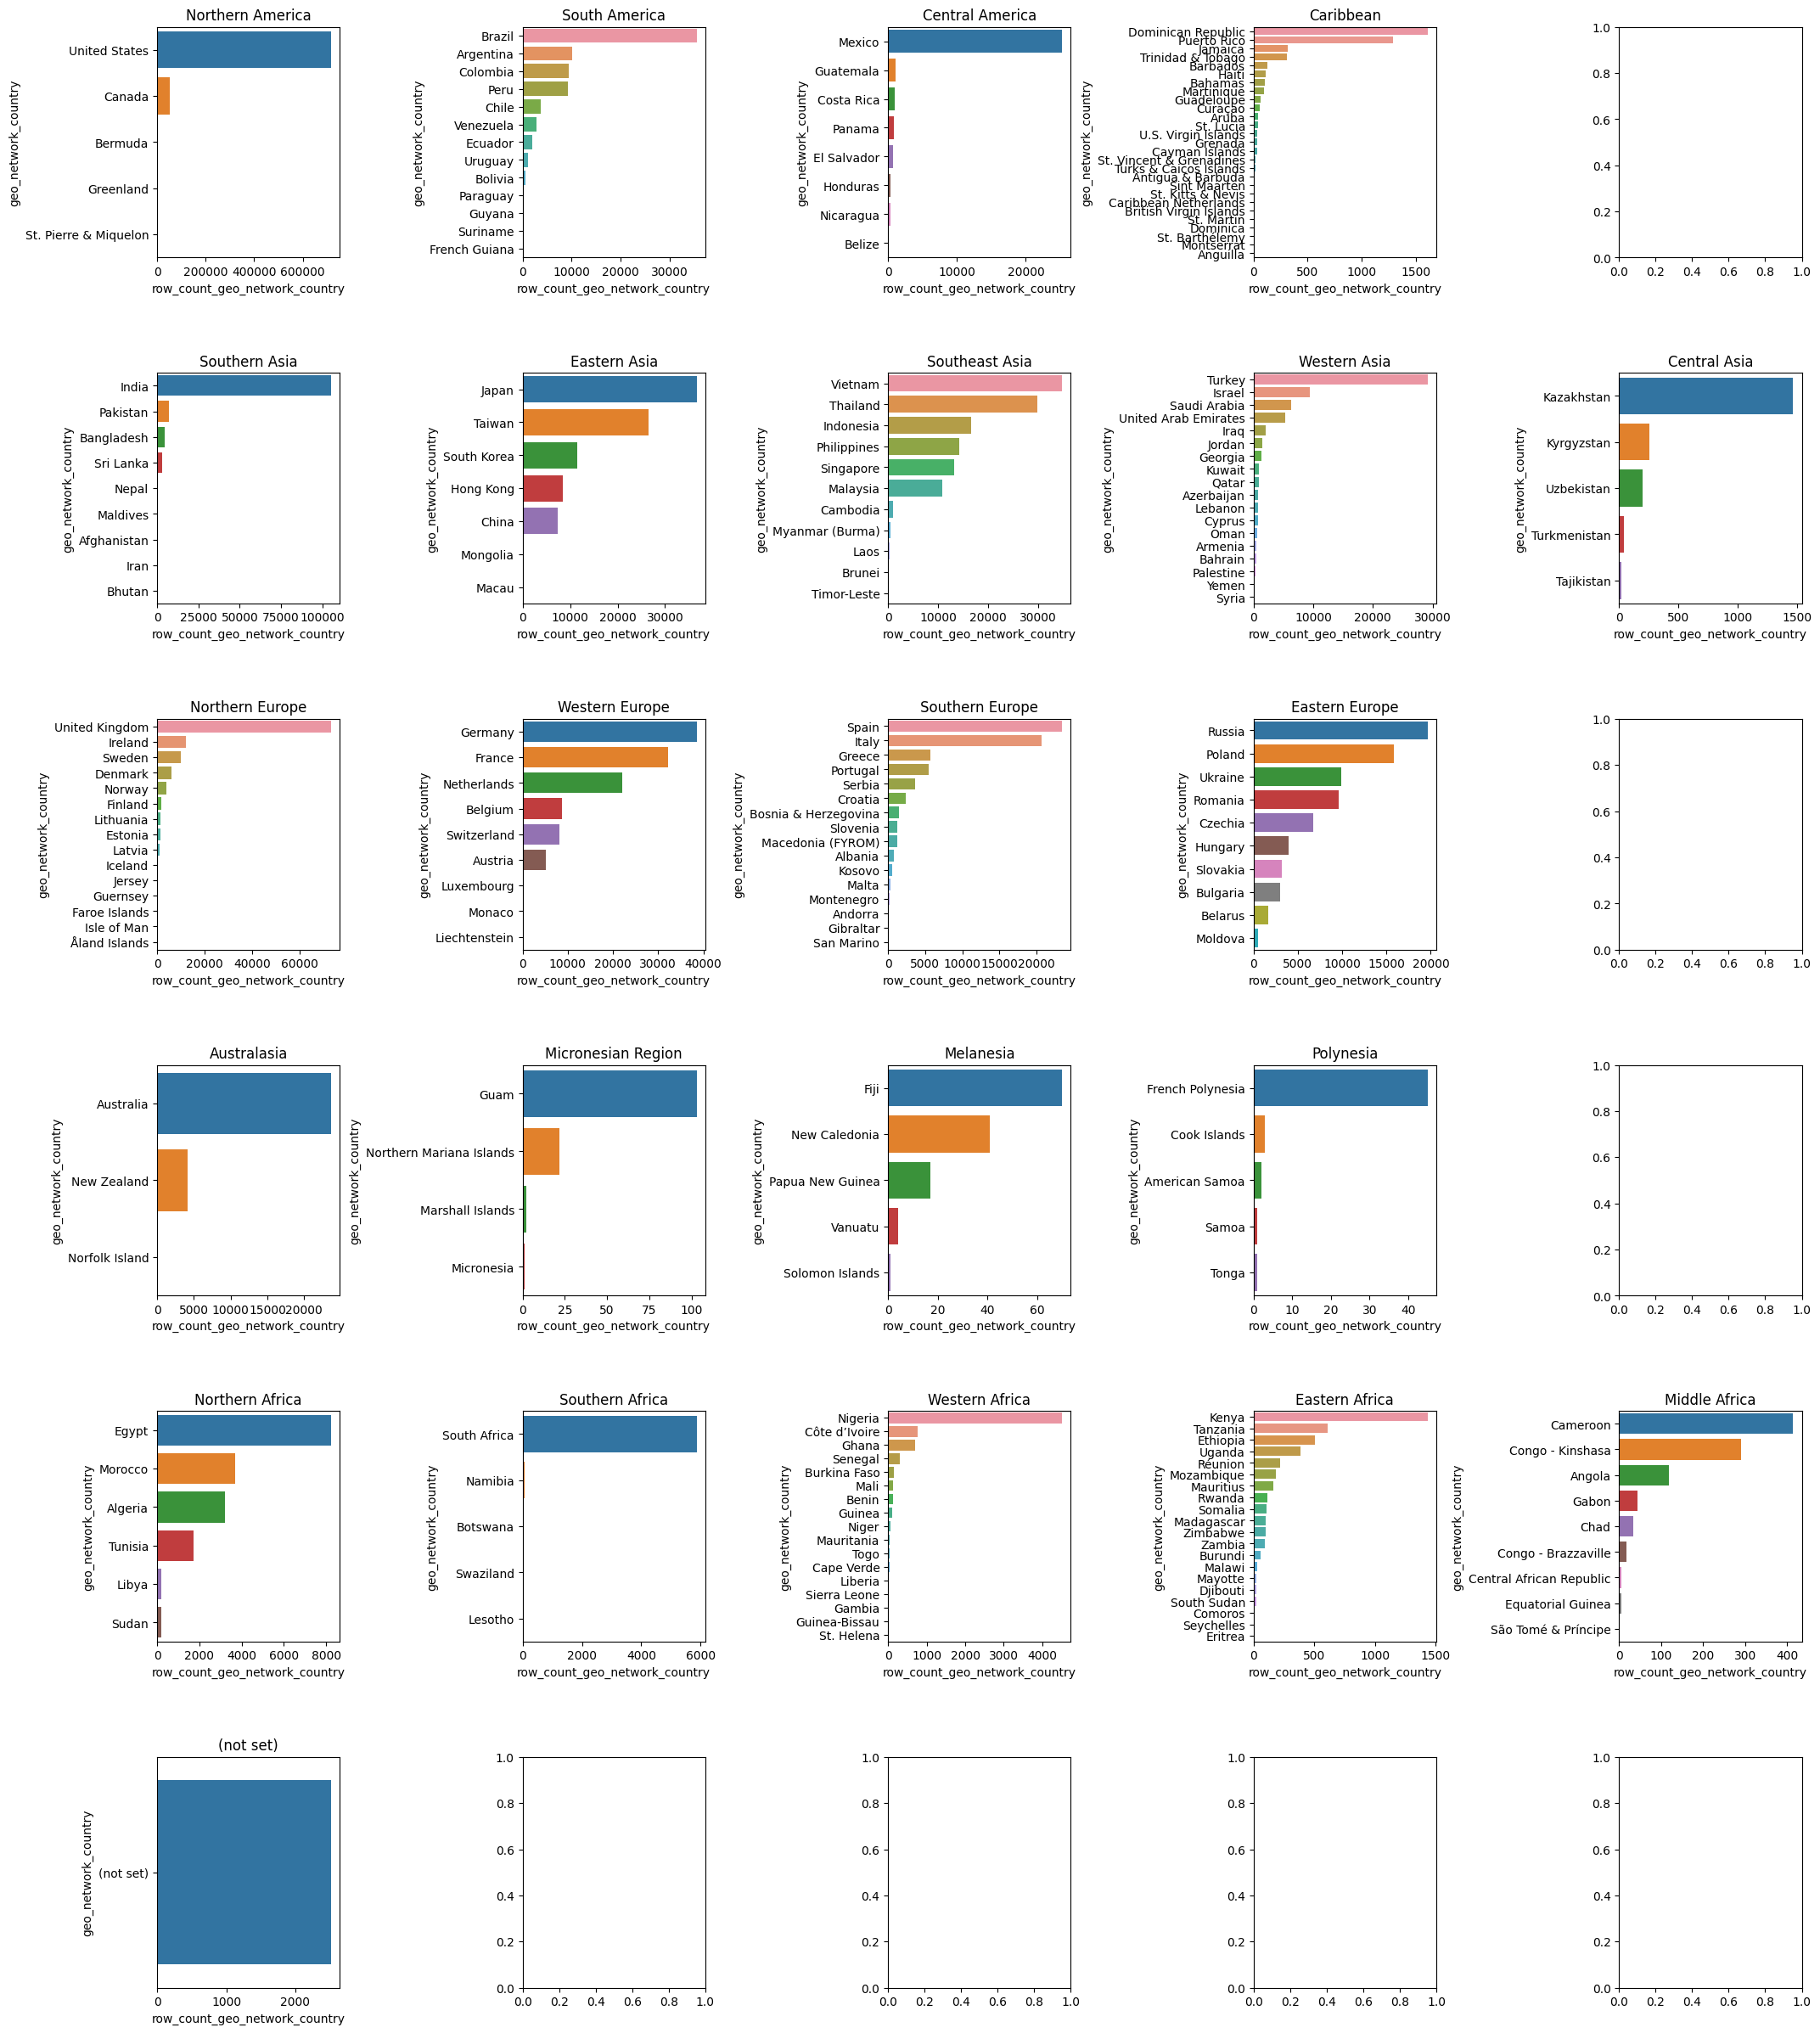

In [57]:
plot_graphs_by_looping(df=geo_network_country_df, row_identifier='geo_network_continent', column_identifier='geo_network_sub_continent', x_column_to_plot='row_count_geo_network_country', y_column_to_plot='geo_network_country', row_count=row_count, max_column_count=max_column_count)

- This graph shows number of rows belonging to each country in a given sub continent. Each row represents a continent

## 8. Analyze geo_network_region

In [58]:
geo_network_region_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_region', group_by_column_list=['geo_network_region'])

In [59]:
geo_network_region_df['percent_geo_network_region'] = geo_network_region_df['row_count_geo_network_region']/geo_network_region_df['row_count_geo_network_region'].sum()

In [60]:
geo_network_region_df.head()

,geo_network_region,row_count_geo_network_region,percent_geo_network_region
0,not available in demo dataset,932959,0.546121
1,California,206669,0.120977
2,(not set),49774,0.029136
3,New York,49733,0.029112
4,England,25824,0.015116


- 54% of rows do not have geo_network_region set. Hence delete this column

## 8. Analyze geo_network_metro

In [61]:
geo_network_metro_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_metro', group_by_column_list=['geo_network_metro'])

In [62]:
geo_network_metro_df['percent_geo_network_metro'] = geo_network_metro_df['row_count_geo_network_metro']/geo_network_metro_df['row_count_geo_network_metro'].sum()

In [63]:
geo_network_metro_df.head()

,geo_network_metro,row_count_geo_network_metro,percent_geo_network_metro
0,not available in demo dataset,932959,0.546121
1,(not set),386896,0.226475
2,San Francisco-Oakland-San Jose CA,182745,0.106972
3,New York NY,50419,0.029513
4,London,23643,0.013840


- Delete column geo_network_metro as 76% rows do not have thsis value.

## 9. Analyze geo_network_city/geo_network_city_id

In [64]:
geo_network_city_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_city', group_by_column_list=['geo_network_city'])

In [65]:
geo_network_city_df['percent_geo_network_city'] = geo_network_city_df['row_count_geo_network_city']/geo_network_city_df['row_count_geo_network_city'].sum()

In [66]:
geo_network_city_df

,geo_network_city,row_count_geo_network_city,percent_geo_network_city
0,not available in demo dataset,932959,0.546121
1,Mountain View,74110,0.043381
2,(not set),65867,0.038556
3,New York,49460,0.028952
4,San Francisco,36960,0.021635
...,...,...,...
951,Daly City,4,0.000002
952,Morgan Hill,4,0.000002
953,North Creek,4,0.000002
954,Boise,3,0.000002


- Delete column geo_network_city as 54% rows do not have this value.

## 10. Analyze geo_network_network_domain

In [67]:
geo_network_network_domain_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_network_domain', group_by_column_list=['geo_network_network_domain'])

In [68]:
geo_network_network_domain_df['domain'] = geo_network_network_domain_df['geo_network_network_domain'].str.split('.').str[1]

In [69]:
geo_network_network_domain_df.head()

,geo_network_network_domain,row_count_geo_network_network_domain,domain
0,(not set),499049,NaN
1,unknown.unknown,269796,unknown
2,comcast.net,55486,net
3,rr.com,28715,com
4,verizon.net,26547,net


- Delete column geo_network_network_domain

## 11. Analyze geo_network_latitude

In [70]:
intermediate_data_table.geo_network_latitude

┌───────────────────────────────┐
│     geo_network_latitude      │
│            varchar            │
├───────────────────────────────┤
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│               ·               │
│               ·               │
│               ·               │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
├───────────────────────────────┤
│ ? rows (>9999 rows, 20 shown) │
└─────────────

- Delete column geo_network_latitude

## 11. Analyze geo_network_longitude

In [71]:
intermediate_data_table.geo_network_longitude

┌───────────────────────────────┐
│     geo_network_longitude     │
│            varchar            │
├───────────────────────────────┤
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│               ·               │
│               ·               │
│               ·               │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
│ not available in demo dataset │
├───────────────────────────────┤
│ ? rows (>9999 rows, 20 shown) │
└─────────────

## 11. Analyze geo_network_network_location

In [72]:
geo_network_network_location_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='geo_network_network_location', group_by_column_list=['geo_network_network_location'])

In [73]:
geo_network_network_location_df

,geo_network_network_location,row_count_geo_network_network_location
0,not available in demo dataset,1708337


## 12. Analyze device_browser
- Relevant device browser: chrome, safari, firefox, internet_explorer, (android_webview, android_browser, android_runtime), edge, samsung_internet, (opera_mini, opera, samsung-sm-b355e_opera), safari_(in-app), uc_browser, yabrowser, amazon_silk, coc_coc, (mozilla_compatible_agent, mozilla), mrchrome, maxthon, puffin, blackberry, nintendo_browser, (nokia_browser, nokiae52), iron, seamonkey, seznam, apple-iphone7c2, playstation_vita_browser, lunascape, konqueror, netscape, mqqbrowser, dillo

In [74]:
device_browser_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser', group_by_column_list=['device_browser'])

In [75]:
device_browser_df['normalized_device_browser'] = device_browser_df['device_browser'].str.lower().str.split(' ').str.join('_')

In [76]:
device_browser_df.head()

,device_browser,row_count_device_browser,normalized_device_browser
0,Chrome,1173056,chrome
1,Safari,312165,safari
2,Firefox,63845,firefox
3,Internet Explorer,35474,internet_explorer
4,Android Webview,34266,android_webview


## 13. Analyze device_browser_version

In [77]:
device_browser_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser_version', group_by_column_list=['device_browser_version'])

In [78]:
device_browser_version_df

,device_browser_version,row_count_device_browser_version
0,not available in demo dataset,1708337


- Delete column device_browser_version

## 14. Analyze device_browser_size

In [79]:
device_browser_size_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_browser_size', group_by_column_list=['device_browser_size'])

In [80]:
device_browser_size_df

,device_browser_size,row_count_device_browser_size
0,not available in demo dataset,1708337


## 15. Analyze device_operating_system

In [81]:
device_operating_system_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_list=['device_operating_system'])

In [82]:
device_operating_system_df.head()

,device_operating_system,row_count_device_operating_system
0,Windows,619720
1,Macintosh,438514
2,Android,299386
3,iOS,219334
4,Linux,63971


### 15.1 How many unique device_operating_system values are associated with a given visitor?

In [83]:
unique_device_operating_system_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [84]:
unique_device_operating_system_per_user_df.unique_count_device_operating_system.value_counts()

unique_count_device_operating_system
1    1328918
2        512
3          3
4          1
Name: count, dtype: int64

- Majority of visitors use only one operating system. Very rarely does it go beyond 1

### 15.2 What are the comma separated unique device_operating_system values associated with each full_visitor_id?

In [85]:
unique_device_operating_system_string_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_name='full_visitor_id', is_distinct_count=True, separator=',')

In [86]:
merged_unique_device_operating_system_string_df = pd.merge(unique_device_operating_system_string_df, unique_device_operating_system_per_user_df, left_on='full_visitor_id', right_on='full_visitor_id', how='left')

In [87]:
merged_unique_device_operating_system_string_df[merged_unique_device_operating_system_string_df.unique_count_device_operating_system.isin([3, 4])]

,full_visitor_id,concatenated_unique_device_operating_system,unique_count_device_operating_system
2932,4078913419231868673,"Android,Macintosh,iOS",3
24125,9076460273340267611,"Android,Linux,Macintosh,Windows",4
836589,5157367009031195155,"Android,Macintosh,iOS",3
1009730,1299148485081161968,"Android,Macintosh,iOS",3


## 16. Analyze device_operating_system_version

In [88]:
device_operating_system_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_operating_system_version', group_by_column_list=['device_operating_system_version'])

In [89]:
device_operating_system_version_df

,device_operating_system_version,row_count_device_operating_system_version
0,not available in demo dataset,1708337


- Delete device_operating_system_version column

## 17. Analyze device_is_mobile

In [90]:
device_is_mobile_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_is_mobile', group_by_column_list=['device_is_mobile'])

In [91]:
device_is_mobile_df

,device_is_mobile,row_count_device_is_mobile
0,False,1171670
1,True,536667


In [92]:
unique_device_operating_system_system_per_device_is_mobile_df = get_separator_separated_values_for_column(con, table_name='intermediate_train_data', count_column_name='device_operating_system', group_by_column_name='device_is_mobile', is_distinct_count=True, separator=',')

In [93]:
unique_device_operating_system_system_per_device_is_mobile_df.loc[0]['concatenated_unique_device_operating_system']

'(not set),Android,Chrome OS,FreeBSD,Linux,Macintosh,Nintendo Wii,OS/2,OpenBSD,SunOS,Tizen,Windows,Xbox,iOS'

In [94]:
unique_device_operating_system_system_per_device_is_mobile_df.loc[1]['concatenated_unique_device_operating_system']

'(not set),Android,BlackBerry,Firefox OS,Linux,Macintosh,NTT DoCoMo,Nintendo 3DS,Nintendo WiiU,Nokia,Playstation Vita,Samsung,SymbianOS,Tizen,Windows,Windows Phone,iOS'

## 18. Analyze device_mobile_device_branding

In [95]:
device_mobile_device_branding_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_branding', group_by_column_list=['device_mobile_device_branding'])

In [96]:
device_mobile_device_branding_df

,device_mobile_device_branding,row_count_device_mobile_device_branding
0,not available in demo dataset,1708337


## 19. Analyze device_mobile_device_model

In [97]:
device_mobile_device_model_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_model', group_by_column_list=['device_mobile_device_model'])

In [98]:
device_mobile_device_model_df

,device_mobile_device_model,row_count_device_mobile_device_model
0,not available in demo dataset,1708337


## 20. Analyze device_mobile_input_selector

In [99]:
device_mobile_input_selector_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_input_selector', group_by_column_list=['device_mobile_input_selector'])

In [100]:
device_mobile_input_selector_df

,device_mobile_input_selector,row_count_device_mobile_input_selector
0,not available in demo dataset,1708337


## 21. Analyze device_mobile_device_info

In [101]:
device_mobile_device_info_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_info', group_by_column_list=['device_mobile_device_info'])

In [102]:
device_mobile_device_info_df

,device_mobile_device_info,row_count_device_mobile_device_info
0,not available in demo dataset,1708337


## 22. Analyze device_mobile_device_marketing_name

In [103]:
device_mobile_device_marketing_name_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_mobile_device_marketing_name', group_by_column_list=['device_mobile_device_marketing_name'])

In [104]:
device_mobile_device_marketing_name_df

,device_mobile_device_marketing_name,row_count_device_mobile_device_marketing_name
0,not available in demo dataset,1708337


## 23. Analyze device_flash_version

In [105]:
device_flash_version_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_flash_version', group_by_column_list=['device_flash_version'])

In [106]:
device_flash_version_df

,device_flash_version,row_count_device_flash_version
0,not available in demo dataset,1708337


## 23. Analyze device_language

In [107]:
device_language_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_language', group_by_column_list=['device_language'])

In [108]:
device_language_df

,device_language,row_count_device_language
0,not available in demo dataset,1708337


## 23. Analyze device_screen_colors

In [109]:
device_screen_colors_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_screen_colors', group_by_column_list=['device_screen_colors'])

In [110]:
device_screen_colors_df

,device_screen_colors,row_count_device_screen_colors
0,not available in demo dataset,1708337


## 23. Analyze device_screen_resolution

In [111]:
device_screen_resolution_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_screen_resolution', group_by_column_list=['device_screen_resolution'])

In [112]:
device_screen_resolution_df

,device_screen_resolution,row_count_device_screen_resolution
0,not available in demo dataset,1708337


## 24. Analyze device_device_category

In [113]:
device_device_category_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_device_category', group_by_column_list=['device_device_category'])

In [114]:
device_device_category_df

,device_device_category,row_count_device_device_category
0,desktop,1171579
1,mobile,471336
2,tablet,65422


### 24.4 How many unique device_device_category values are associated with a user identified by full_visitor_id

In [115]:
unique_device_device_category_per_user_df = get_counts_for_column_entries_ddb_table(con, table_name='intermediate_train_data', count_column_name='device_device_category', group_by_column_list=['full_visitor_id'], is_distinct_count=True)

In [116]:
unique_device_device_category_per_user_df.unique_count_device_device_category.value_counts()

unique_count_device_device_category
1    1329434
Name: count, dtype: int64

- Very interseting to see that every visitor uses only 1 unique device_device_category

## 25. Analyze totals - This section contains aggregate values across the session [TODO AGAIN CORRECTLY]
- https://www.digishuffle.com/blogs/google-analytics-sessions-hits-metric-simplified/
- https://themeisle.com/blog/page-views-vs-visits/#gref

3. Session: A session is the total time a user spends on your website within a certain period. A session typically expires after 30 minutes of inactivity. A session is a group of user interactions with your website that take place within a given time frame

Note: Contrary to popular belief, high page views don’t always mean you’re reaching a broad audience. High page visits are generally positive, as they indicate that your website is popular.

### 25.1 totals_visits
- Page Visit: A page visit happens whenever someone reaches your site from an external source, outside of your website’s domain. For instance, if a user finds your article online and then reloads the page, that still counts as one visit. However, if they navigate away from your website, search for a new keyword in Google, and then land on your page again, this will count as two visits


In [194]:
totals_visits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_visits', ['full_visitor_id'])

In [195]:
totals_visits_per_user_aggregates_df.head()

,full_visitor_id,min_totals_visits_per_session,max_totals_visits_per_session,sum_totals_visits,avg_totals_visits_per_session,median_totals_visits_per_session,session_count
0,303782851105236020,1.0,1.0,1.0,1.0,1.0,1
1,4956424076854174193,1.0,1.0,1.0,1.0,1.0,1
2,3597856604712149727,1.0,1.0,1.0,1.0,1.0,1
3,4594103331432511403,1.0,1.0,1.0,1.0,1.0,1
4,2977627662304426600,1.0,1.0,1.0,1.0,1.0,1


In [196]:
totals_visits_per_user_aggregates_df.min_totals_visits_per_session.describe()

count    1329434.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: min_totals_visits_per_session, dtype: float64

In [197]:
totals_visits_per_user_aggregates_df.max_totals_visits_per_session.describe()

count    1329434.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: max_totals_visits_per_session, dtype: float64

In [198]:
totals_visits_per_user_aggregates_df.avg_totals_visits_per_session.describe()

count    1329434.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: avg_totals_visits_per_session, dtype: float64

In [199]:
totals_visits_per_user_aggregates_df.session_count.describe()

count    1.329434e+06
mean     1.285011e+00
std      1.529400e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+02
Name: session_count, dtype: float64

In [200]:
totals_visits_per_user_aggregates_df[totals_visits_per_user_aggregates_df.session_count > 300]

,full_visitor_id,min_totals_visits_per_session,max_totals_visits_per_session,sum_totals_visits,avg_totals_visits_per_session,median_totals_visits_per_session,session_count
167069,1957458976293878100,1.0,1.0,400.0,1.0,1.0,400
667786,7282998257608986241,1.0,1.0,315.0,1.0,1.0,315


- This shows that each visitor/full_visitor_id has exactly 1 visit per session. Even the visitor having 400 sessions, has maximum of 1 visit across each of 400 sessions.
- Possible features:
1. Before a date, how many visits per session have been made?
2. Before a date, total number of visits?
3. Before a date, min, max, avg, median visits per session?

### 25.2 totals_pageviews [Type of interaction hit]
- Page View: A page view occurs whenever someone loads your site in their web browser (not necessary to be from external source). A view is registered every time a page is loaded. 

In [201]:
totals_pageviews_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_pageviews', ['full_visitor_id'])

In [202]:
totals_pageviews_per_user_aggregates_df.head()

,full_visitor_id,min_totals_pageviews_per_session,max_totals_pageviews_per_session,sum_totals_pageviews,avg_totals_pageviews_per_session,median_totals_pageviews_per_session,session_count
0,9533740083649729318,11.0,11.0,11.0,11.0,11.0,1
1,7408971631208162978,13.0,13.0,13.0,13.0,13.0,1
2,6044523443673656030,11.0,11.0,11.0,11.0,11.0,1
3,9498014087557758935,1.0,9.0,20.0,5.0,5.0,4
4,6384478286528802633,12.0,12.0,12.0,12.0,12.0,1


In [203]:
totals_pageviews_per_user_aggregates_df[totals_pageviews_per_user_aggregates_df.session_count>300]

,full_visitor_id,min_totals_pageviews_per_session,max_totals_pageviews_per_session,sum_totals_pageviews,avg_totals_pageviews_per_session,median_totals_pageviews_per_session,session_count
167261,1957458976293878100,1.0,483.0,7407.0,18.517500,5.0,400
665988,7282998257608986241,1.0,115.0,1480.0,4.698413,2.0,315


### 25.3 totals_hits [Interaction + non interaction hits = Screenview hit, PageView Hit, Event Hit, Exception Hit, Ecommerce Hit, Social INteraction Hit, User Timing Hit]
- A Hit is an interaction that results in data being sent to Analytics. 2 types: Interaction and non interaction hits

In [204]:
totals_hits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_hits', ['full_visitor_id'])

In [205]:
totals_hits_per_user_aggregates_df[totals_hits_per_user_aggregates_df.session_count>300]

,full_visitor_id,min_totals_hits_per_session,max_totals_hits_per_session,sum_totals_hits,avg_totals_hits_per_session,median_totals_hits_per_session,session_count
167261,1957458976293878100,1.0,483.0,8393.0,20.982500,6.0,400
665988,7282998257608986241,1.0,155.0,1672.0,5.307937,2.0,315


- Clearly, there are some people who have a large distribution of hits per session.

In [206]:
res = con.execute("select CAST (totals_hits AS DOUBLE) AS totals_hits from intermediate_train_data where full_visitor_id = '7282998257608986241'").df()

[Text(0.5, 1.0, 'Example distribution of totals_hits for full_visitor_id = 824839726118485274')]

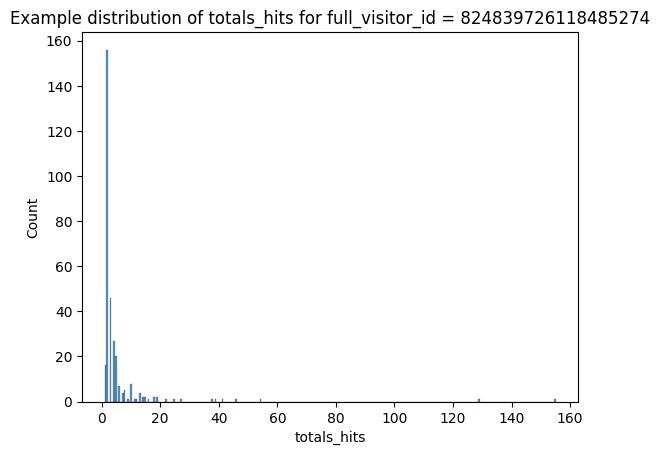

In [207]:
sns.histplot(data=res, x='totals_hits').set(title='Example distribution of totals_hits for full_visitor_id = 824839726118485274')

### 25.4 totals_time_on_site

In [208]:
totals_time_on_site_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_time_on_site', ['full_visitor_id'])

- This column is not recorded for majority of rows. Hence drop it

### 25.4 totals_new_visits

In [209]:
totals_new_visits_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_new_visits', ['full_visitor_id'])

- Drop totals_new_visits column

### 25.5 totals_session_quality_dim -> Drop column

### 25.6 totals_transactions

In [210]:
totals_transactions_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_transactions', ['full_visitor_id'])

In [211]:
totals_transactions_per_user_aggregates_df[~totals_transactions_per_user_aggregates_df['min_totals_transactions_per_session'].isnull()].sort_values(by=['session_count'], ascending=False).head()

,full_visitor_id,min_totals_transactions_per_session,max_totals_transactions_per_session,sum_totals_transactions,avg_totals_transactions_per_session,median_totals_transactions_per_session,session_count
166525,1957458976293878100,1.0,3.0,33.0,0.082500,1.0,400
1164068,7477638593794484792,1.0,1.0,1.0,0.004587,1.0,218
997861,3608475193341679870,1.0,1.0,1.0,0.004975,1.0,201
998292,460252456180441002,1.0,1.0,2.0,0.012346,1.0,162
1001154,3269834865385146569,1.0,1.0,1.0,0.006369,1.0,157


In [187]:
#con.execute("select CAST (totals_transactions AS DOUBLE) AS totals_transactions from intermediate_train_data where full_visitor_id = '3269834865385146569'").df()

### 25.6 totals_transaction_revenue

In [212]:
totals_transaction_revenue_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_transaction_revenue', ['full_visitor_id'])

In [214]:
totals_transaction_revenue_per_user_aggregates_df.head()

,full_visitor_id,min_totals_transaction_revenue_per_session,max_totals_transaction_revenue_per_session,sum_totals_transaction_revenue,avg_totals_transaction_revenue_per_session,median_totals_transaction_revenue_per_session,session_count
0,1188438204350710034,NaN,NaN,NaN,0.000000e+00,NaN,1
1,4995584940873803432,27190000.0,108760000.0,135950000.0,1.045769e+07,67975000.0,13
2,9431335736445969971,NaN,NaN,NaN,0.000000e+00,NaN,11
3,5545356997493092750,NaN,NaN,NaN,0.000000e+00,NaN,1
4,4725525313554504933,NaN,NaN,NaN,0.000000e+00,NaN,1


In [218]:
totals_transaction_revenue_per_user_aggregates_df.min_totals_transaction_revenue_per_session.isnull().value_counts(normalize=True)

min_totals_transaction_revenue_per_session
True     0.987813
False    0.012187
Name: proportion, dtype: float64

- Only 1.2% of visitors ever make a transaction. Remaining 98.7% never make a transaction across all their sessions

### 25.7 totals_total_transaction_revenue

In [219]:
totals_total_transaction_revenue_per_user_aggregates_df = get_aggregates_for_numerical_variable_using_groupby_column(con, 'intermediate_train_data', 'totals_total_transaction_revenue', ['full_visitor_id'])

In [220]:
totals_total_transaction_revenue_per_user_aggregates_df

,full_visitor_id,min_totals_total_transaction_revenue_per_session,max_totals_total_transaction_revenue_per_session,sum_totals_total_transaction_revenue,avg_totals_total_transaction_revenue_per_session,median_totals_total_transaction_revenue_per_session,session_count
0,6634928957967039943,NaN,NaN,NaN,0.0,NaN,1
1,9885468242604668053,NaN,NaN,NaN,0.0,NaN,1
2,2587584175739086572,NaN,NaN,NaN,0.0,NaN,1
3,4170854420751148212,NaN,NaN,NaN,0.0,NaN,22
4,130939267156629446,NaN,NaN,NaN,0.0,NaN,1
...,...,...,...,...,...,...,...
1329429,3552107227896433118,NaN,NaN,NaN,0.0,NaN,1
1329430,3579436755175972276,NaN,NaN,NaN,0.0,NaN,1
1329431,4113481277117785673,NaN,NaN,NaN,0.0,NaN,1
1329432,5986748383523874055,NaN,NaN,NaN,0.0,NaN,1


In [221]:
scatter_data = con.execute("select CAST(totals_transaction_revenue AS DOUBLE) AS totals_transaction_revenue, CAST(totals_total_transaction_revenue AS DOUBLE) AS totals_total_transaction_revenue from intermediate_train_data").df()

<Axes: xlabel='totals_transaction_revenue', ylabel='totals_total_transaction_revenue'>

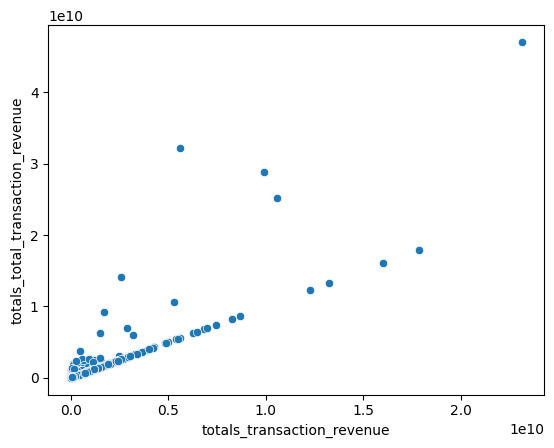

In [222]:
sns.scatterplot(data=scatter_data, x="totals_transaction_revenue", y="totals_total_transaction_revenue")

In [188]:
intermediate_data_table.columns

['channel_grouping',
 'date',
 'full_visitor_id',
 'social_engagement_type',
 'visit_id',
 'visit_number',
 'visit_start_time',
 'geo_network_continent',
 'geo_network_sub_continent',
 'geo_network_country',
 'geo_network_region',
 'geo_network_metro',
 'geo_network_city',
 'geo_network_city_id',
 'geo_network_network_domain',
 'geo_network_latitude',
 'geo_network_longitude',
 'geo_network_network_location',
 'device_browser',
 'device_browser_version',
 'device_browser_size',
 'device_operating_system',
 'device_operating_system_version',
 'device_is_mobile',
 'device_mobile_device_branding',
 'device_mobile_device_model',
 'device_mobile_input_selector',
 'device_mobile_device_info',
 'device_mobile_device_marketing_name',
 'device_flash_version',
 'device_language',
 'device_screen_colors',
 'device_screen_resolution',
 'device_device_category',
 'totals_visits',
 'totals_hits',
 'totals_pageviews',
 'totals_time_on_site',
 'totals_new_visits',
 'totals_session_quality_dim',
 'tota

## TODO:
1. Delete social_engagement_type, geo_network_region, geo_network_metro, geo_network_city, geo_network_city_id, geo_network_network_domain, geo_network_latitude, geo_network_longitude, geo_network_network_location, device_browser_version, device_browser_size, device_operating_system_version, device_mobile_device_branding, device_mobile_device_model, device_mobile_input_selector, device_mobile_device_info, device_mobile_device_marketing_name, device_flash_version, device_language, device_screen_colors, device_screen_resolution, totals_time_on_site, totals_new_visits, totals_session_quality_dim
2. Convert visit_start_time to date. Also try to map it to local time where the person was located wrt UTC
3. Column: geo_network_continent, geo_network_sub_continent, geo_network_country, geo_network_region, geo_network_network_domain, device_operating_system => Replace (not set) with 'unknown'
4. Set datatype to numeric: totals_visits
5. Use totals_transaction_revenue column to create GT labels

## Ideas:
1. Can get income level for visitor from geo_network_city.??
2. FEATURE: Number of transactions/session